image1.png:
  Skewness        : 0.0261
  Uniformity      : 0.0228
  Average Entropy : 5.6994


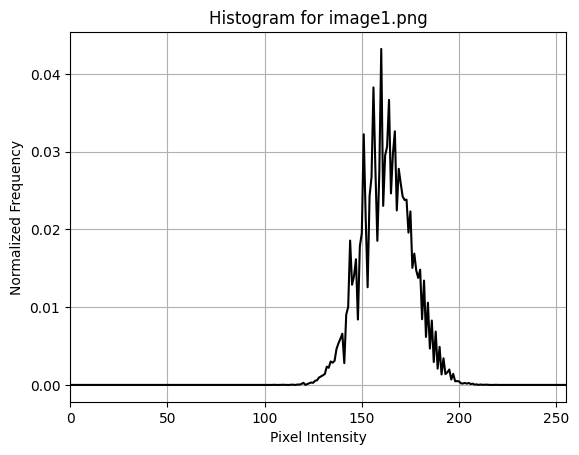

image2.png:
  Skewness        : -0.0311
  Uniformity      : 0.0121
  Average Entropy : 6.7846


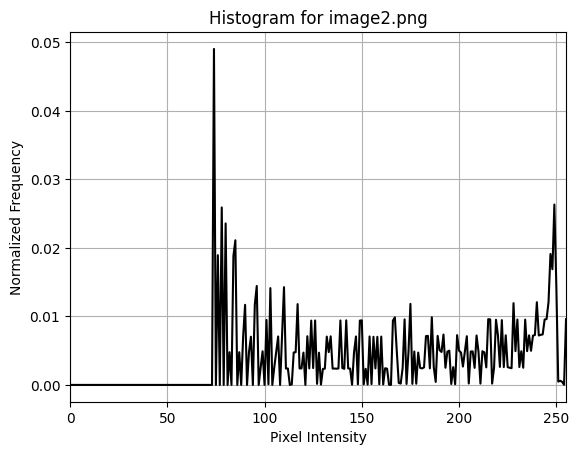

image3.png:
  Skewness        : 0.3974
  Uniformity      : 0.0078
  Average Entropy : 7.2041


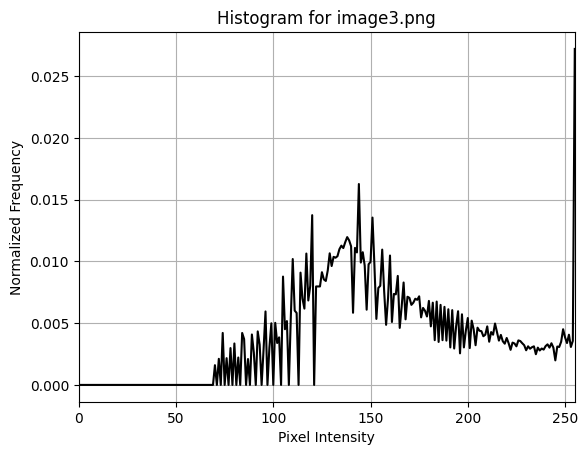

image4.png:
  Skewness        : 0.9670
  Uniformity      : 0.0101
  Average Entropy : 7.1655


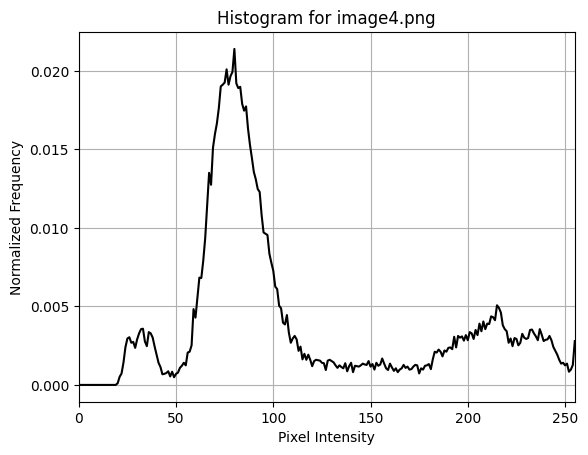

image5.png:
  Skewness        : 1.0078
  Uniformity      : 0.0094
  Average Entropy : 7.2439


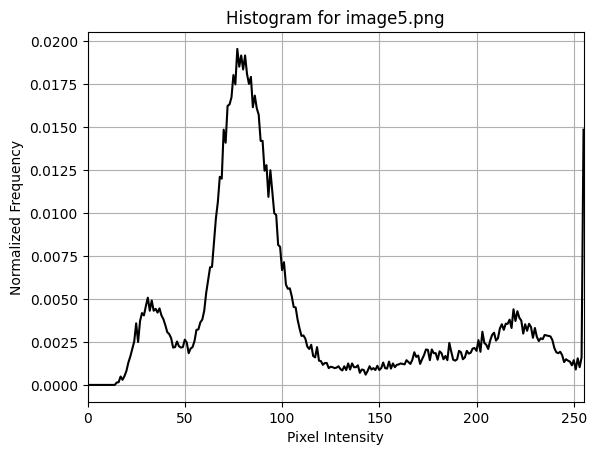

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_histogram(image):
    hist = np.zeros(256, dtype=np.float32)
    for value in image.ravel():
        hist[value] += 1
    hist_norm = hist / np.sum(hist)
    return hist_norm

def compute_skewness(hist):
    values = np.arange(256)
    mean = np.sum(values * hist)
    std = np.sqrt(np.sum((values - mean) ** 2 * hist))
    skewness = np.sum(((values - mean) ** 3) * hist) / (std ** 3 + 1e-10) 
    return skewness

def compute_uniformity(hist):
    return np.sum(hist ** 2)

def compute_entropy(hist):
    non_zero_hist = hist[hist > 0]
    return -np.sum(non_zero_hist * np.log2(non_zero_hist))

def analyze_image(image_path):
    image = cv2.imread(image_path, 0)
    hist = compute_histogram(image)
    skew_val = compute_skewness(hist)
    uniformity_val = compute_uniformity(hist)
    entropy_val = compute_entropy(hist)

    return hist, skew_val, uniformity_val, entropy_val

def process_images_from_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        hist, skew_val, uniformity_val, entropy_val = analyze_image(image_path)
        print(f"{filename}:")
        print(f"  Skewness        : {skew_val:.4f}")
        print(f"  Uniformity      : {uniformity_val:.4f}")
        print(f"  Average Entropy : {entropy_val:.4f}")
        plt.figure()
        plt.title(f"Histogram for {filename}")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Normalized Frequency")
        plt.plot(hist, color='black')
        plt.xlim([0, 255])
        plt.grid(True)
        plt.show()

folder_path = "images"  
process_images_from_folder(folder_path)


  Manual Uniformity : 0.0007
  Manual Entropy    : 10.9174



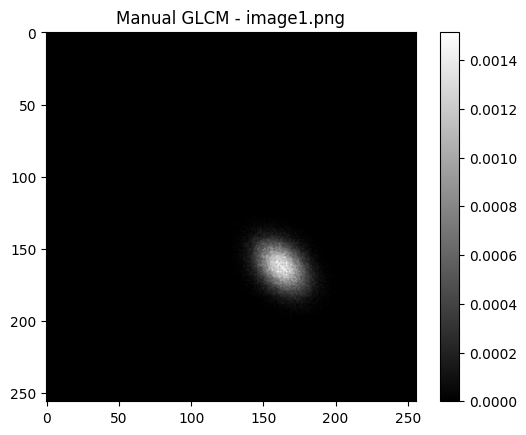

  Manual Uniformity : 0.0018
  Manual Entropy    : 9.4310



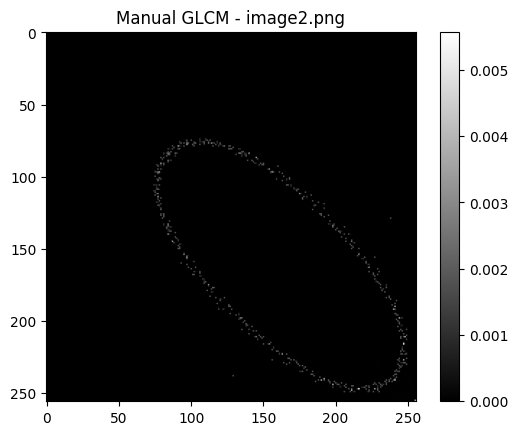

  Manual Uniformity : 0.0004
  Manual Entropy    : 13.4105



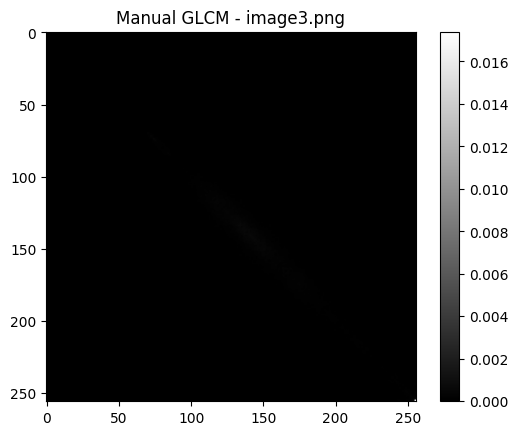

  Manual Uniformity : 0.0005
  Manual Entropy    : 12.3424



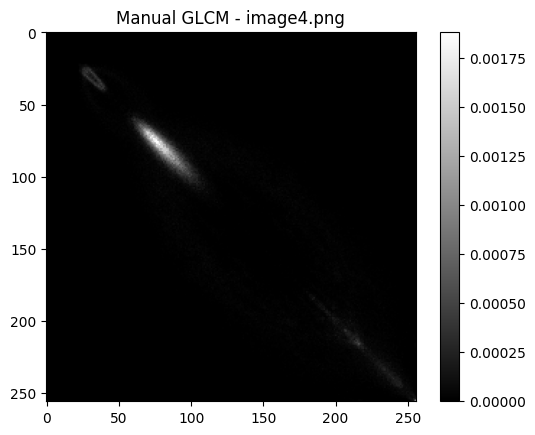

  Manual Uniformity : 0.0006
  Manual Entropy    : 12.1433



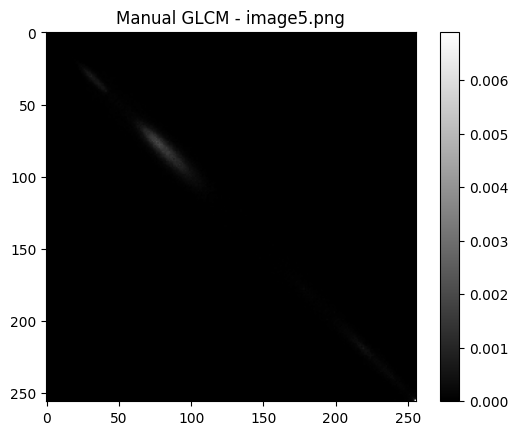

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import entropy

def compute_glcm_manual(image, dx=1, dy=0, levels=256):
    glcm = np.zeros((levels, levels), dtype=np.float32)
    h, w = image.shape

    for i in range(h - dy):
        for j in range(w - dx):
            row = image[i, j]
            col = image[i + dy, j + dx]
            glcm[row, col] += 1

    glcm += glcm.T  
    glcm /= glcm.sum()  
    return glcm

def compute_uniformity(glcm):
    return np.sum(glcm ** 2)

def compute_entropy(glcm):
    return entropy(glcm.ravel() + 1e-10, base=2)

def analyze_image_manual_glcm(image_path):
    image = cv2.imread(image_path, 0)
    image = cv2.resize(image, (256, 256))
    glcm = compute_glcm_manual(image, dx=1, dy=0)
    uniformity = compute_uniformity(glcm)
    ent = compute_entropy(glcm)

    print(f"  Manual Uniformity : {uniformity:.4f}")
    print(f"  Manual Entropy    : {ent:.4f}\n")

    plt.figure()
    plt.title(f"Manual GLCM - {os.path.basename(image_path)}")
    plt.imshow(glcm, cmap='gray')
    plt.colorbar()
    plt.show()

def process_folder_manual(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    for fname in image_files:
        analyze_image_manual_glcm(os.path.join(folder_path, fname))

folder_path = "images"
process_folder_manual(folder_path)


Processing image4.png...


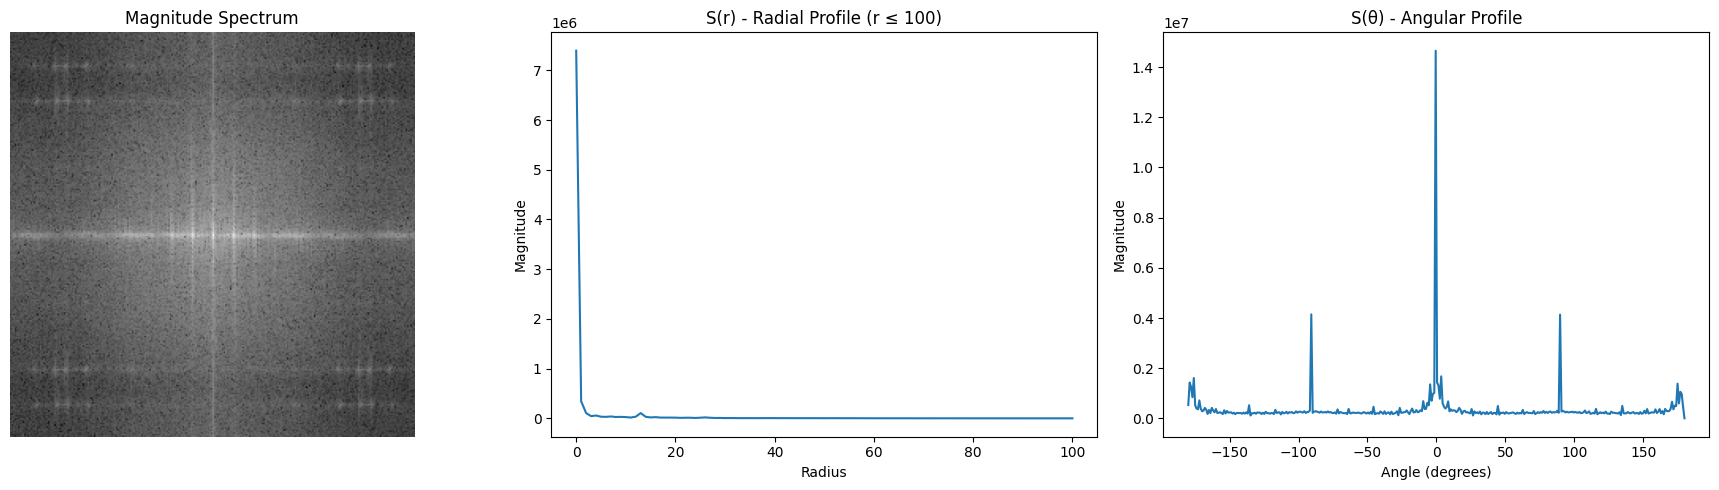

Processing image5.png...


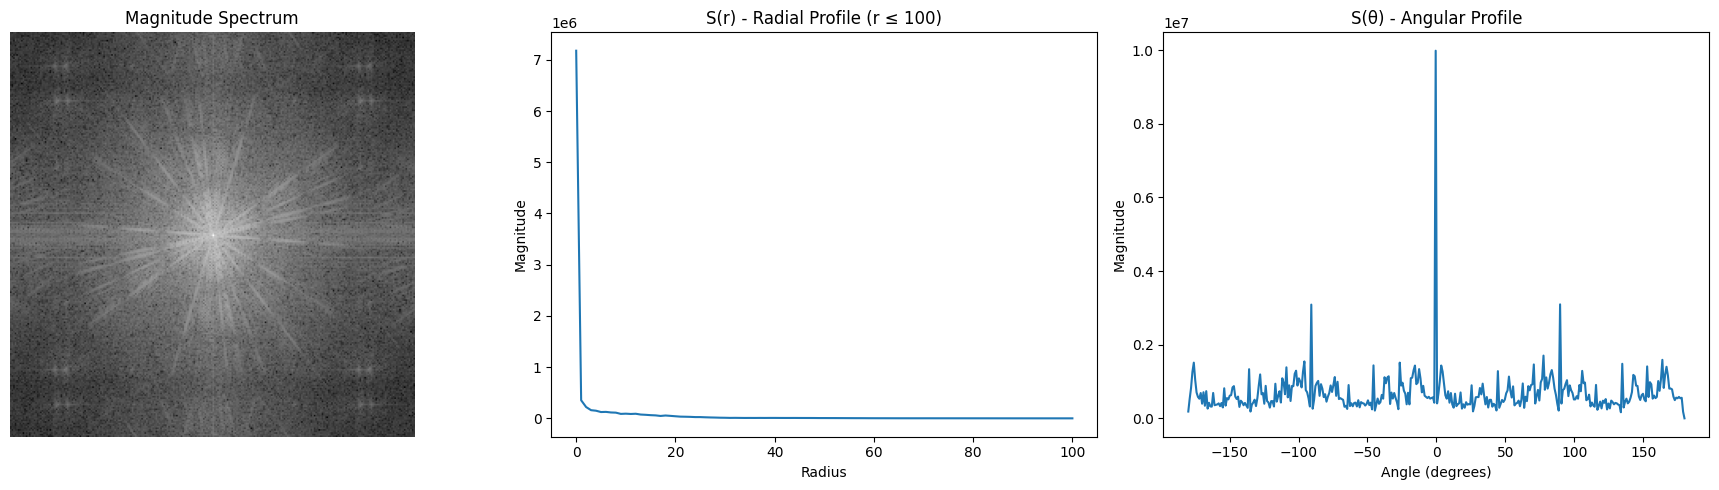

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def fft_magnitude_spectrum(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude = np.abs(fshift)
    return magnitude

def compute_spectral_profiles(magnitude):
    h, w = magnitude.shape
    cy, cx = h // 2, w // 2
    Y, X = np.indices((h, w))
    R = np.sqrt((X - cx)**2 + (Y - cy)**2)
    Theta = np.arctan2(Y - cy, X - cx)

    R = R.astype(int)

    r_max = int(np.max(R))
    S_r = np.zeros(r_max + 1)
    counts_r = np.zeros(r_max + 1)

    for r_val in range(r_max + 1):
        mask = (R == r_val)
        S_r[r_val] = np.sum(magnitude[mask])
        counts_r[r_val] = np.sum(mask)

    S_r /= counts_r + 1e-10 

    theta_bins = 360
    theta_vals = np.linspace(-np.pi, np.pi, theta_bins)
    S_theta = np.zeros(theta_bins)

    for i in range(theta_bins - 1):
        mask = (Theta >= theta_vals[i]) & (Theta < theta_vals[i+1])
        S_theta[i] = np.sum(magnitude[mask])

    return S_r, S_theta

def analyze_spectral(image_path):
    image = cv2.imread(image_path, 0)
    image = cv2.resize(image, (256, 256))  
    magnitude = fft_magnitude_spectrum(image)
    S_r, S_theta = compute_spectral_profiles(magnitude)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].imshow(np.log(1+magnitude), cmap='gray')
    axs[0].set_title("Magnitude Spectrum")
    axs[0].axis("off")

    axs[1].plot(S_r)
    axs[1].set_title("S(r) - Radial Profile")
    axs[1].set_xlabel("Radius")
    axs[1].set_ylabel("Magnitude")

    axs[2].plot(np.degrees(np.linspace(-np.pi, np.pi, len(S_theta))), S_theta)
    axs[2].set_title("S(θ) - Angular Profile")
    axs[2].set_xlabel("Angle (degrees)")
    axs[2].set_ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

def process_folder_spectral(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    for fname in image_files:
        analyze_spectral(os.path.join(folder_path, fname))
folder_path = "images/image2"
process_folder_spectral(folder_path)